In [9]:
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import geopandas as gpd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import rasterio
from rasterio.sample import sample_gen
from src.mplstyle import set as set_mplstyle
set_mplstyle("Fira Sans")

GHCND_PATH = Path("/mnt/d/climate_data/ghcnd/data/")
DATA_DOC_PATH = Path("./data/dataset_docs/")
OE_PATH = Path("/mnt/d/climate_data/HPD_CONUS_OEVENTS/")
ERA5_PATH = Path("/mnt/d/climate_data/ERA5_CONUS_STATIONS/")

OUTPUT_PATH = Path("./output/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

MERGED_OE_PATH = Path("./data/OE_tmean_era5/")
MERGED_OE_PATH.mkdir(parents=True, exist_ok=True)

KG_RASTER_PATH = Path("./data/CONUS_Beck_KG_V1_Present.tif")

KOPPEN_DATA = {
        1:  ('Af - Tropical, rainforest', [0, 0, 255]),
        2:  ('Am - Tropical, monsoon', [0, 120, 255]),
        3:  ('Aw - Tropical, savannah', [70, 170, 250]),
        4:  ('BWh - Arid, desert, hot', [255, 0, 0]),
        5:  ('BWk - Arid, desert, cold', [255, 150, 150]),
        6:  ('BSh - Arid, steppe, hot', [245, 165, 0]),
        7:  ('BSk - Arid, steppe, cold', [255, 220, 100]),
        8:  ('Csa - Temperate, dry summer, hot summer', [255, 255, 0]),
        9:  ('Csb - Temperate, dry summer, warm summer', [200, 200, 0]),
        10: ('Csc - Temperate, dry summer, cold summer', [150, 150, 0]),
        11: ('Cwa - Temperate, dry winter, hot summer', [150, 255, 150]),
        12: ('Cwb - Temperate, dry winter, warm summer', [100, 200, 100]),
        13: ('Cwc - Temperate, dry winter, cold summer', [50, 150, 50]),
        14: ('Cfa - Temperate, no dry season, hot summer', [200, 255, 80]),
        15: ('Cfb - Temperate, no dry season, warm summer', [100, 255, 80]),
        16: ('Cfc - Temperate, no dry season, cold summer', [50, 200, 0]),
        17: ('Dsa - Cold, dry summer, hot summer', [255, 0, 255]),
        18: ('Dsb - Cold, dry summer, warm summer', [200, 0, 200]),
        19: ('Dsc - Cold, dry summer, cold summer', [150, 50, 150]),
        20: ('Dsd - Cold, dry summer, very cold winter', [150, 100, 150]),
        21: ('Dwa - Cold, dry winter, hot summer', [170, 175, 255]),
        22: ('Dwb - Cold, dry winter, warm summer', [90, 120, 220]),
        23: ('Dwc - Cold, dry winter, cold summer', [75, 80, 180]),
        24: ('Dwd - Cold, dry winter, very cold winter', [50, 0, 135]),
        25: ('Dfa - Cold, no dry season, hot summer', [0, 255, 255]),
        26: ('Dfb - Cold, no dry season, warm summer', [55, 200, 255]),
        27: ('Dfc - Cold, no dry season, cold summer', [0, 125, 125]),
        28: ('Dfd - Cold, no dry season, very cold winter', [0, 70, 95]),
        29: ('ET - Polar, tundra', [178, 178, 178]),
        30: ('EF - Polar, frost', [102, 102, 102])
    }

In [10]:
############################################## DATA PROCESSING ################################################

def load_stn_tmean(stn_id):
    """
    Load GHCN-d TMEAN data that passed QC into a dataframe with datetime index
    """
    # Load and reindex data
    df = pd.read_csv(
        GHCND_PATH / f"{stn_id}.csv",
        low_memory=False,
        usecols=["DATE", "TMAX", "TMIN", "TMAX_ATTRIBUTES", "TMIN_ATTRIBUTES"],
        index_col="DATE",
        parse_dates=True,
        na_values=[9999, -9999],
    ).asfreq("D")

    # Remove flagged data
    tmax_split = df["TMAX_ATTRIBUTES"].str.split(",", expand=True)
    tmin_split = df["TMIN_ATTRIBUTES"].str.split(",", expand=True)

    ## Set to NaN if flag1 or flag2 is not empty
    df.loc[(tmax_split[0] != "") | (tmax_split[1] != ""), "TMAX"] = np.nan
    df.loc[(tmin_split[0] != "") | (tmin_split[1] != ""), "TMIN"] = np.nan

    df["TMEAN"] = (df["TMAX"] + df["TMIN"]) / 20  # TEMP data stored as tenth of Celsius

    return df.drop(columns=["TMAX", "TMIN", "TMAX_ATTRIBUTES", "TMIN_ATTRIBUTES"])


def aggregate_24h_leading_window(prcp_df, era5_df):
    """
    For each precipitation event, compute W500 mean and VIMC sum 
    over the 24h period leading to the event (inclusive of event time).
    """
    results = []
    
    for prcp_time in prcp_df.index:
        # Define the 24h window: from (prcp_time - 23h) to prcp_time (inclusive)
        start_time = prcp_time - pd.Timedelta(hours=23)
        end_time = prcp_time
        window_data = era5_df.loc[start_time:end_time]
        
        if len(window_data) == 24:
            # Compute aggregated values
            w500_mean = window_data["W500"].mean()
            vimc_sum = window_data["VIMC"].sum()
            
            results.append({
                'datetime': prcp_time,
                'W500': w500_mean,
                'VIMC': vimc_sum,
                #'n_hours': len(window_data)
            })
        else:
            results.append({
                'datetime': prcp_time,
                'W500': pd.NA,
                'VIMC': pd.NA,
                #'n_hours': 0
            })
    
    result_df = pd.DataFrame(results)
    result_df.set_index('datetime', inplace=True)
    
    return result_df

def merge_hpd_events_with_exg(prcp_df, tmean_df, era5_df, duration):
    """
    Load ordinary events data of a given duration and merge it with an exogenous variable dataframe
    """
    prcp_df["DATE"] = (
        prcp_df.index.normalize()
    ) 
    if duration == "24h":
        era5_df = aggregate_24h_leading_window(prcp_df, era5_df)
        
    merged = (
        prcp_df.merge(era5_df, how="left", left_index=True, right_index=True)
        .merge(tmean_df, how="left", on="DATE") # Match prcp with daily temperature on the day of the event
        .drop(columns=["DATE"])
    )
    merged.index = prcp_df.index
    return merged


############################################## KG CLASSIFICATION #######################################################
def create_koppen_colormap():
    """
    Create a custom colormap for Köppen climate classifications
    """
    
    # Create color list (normalized to 0-1 range)
    colors = []
    labels = []
    values = []
    
    for value in range(1, 31):
        label, rgb = KOPPEN_DATA[value]
        colors.append([c/255.0 for c in rgb])  # Normalize RGB to 0-1
        labels.append(label)
        values.append(value)
    cmap = mcolors.ListedColormap(colors)
    return cmap, labels, values


def extract_climate_classification(stations_df, raster_path, lat_col='Lat', lon_col='Lon'):
    """
    Extract climate classification values from raster data at station locations
    
    Parameters:
    -----------
    stations_df : pandas.DataFrame
        DataFrame containing station information with latitude and longitude columns
    raster_path : str
        Path to the Köppen climate classification raster file
    lat_col : str
        Name of the latitude column (default: 'Lat')
    lon_col : str
        Name of the longitude column (default: 'Lon')
    
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with added 'KG' column containing climate classification values
    """
    
    # Make a copy of the original dataframe
    stations_copy = stations_df.copy()
    
    # Open the raster file
    with rasterio.open(raster_path) as src:
        coords = [(lon, lat) for lon, lat in zip(stations_copy[lon_col], stations_copy[lat_col])]
        
        # Sample the raster at the coordinate locations
        sampled_values = [val[0] for val in sample_gen(src, coords)]

        stations_copy['KG'] = sampled_values
        stations_copy['KG'] = stations_copy['KG'].astype('Int64') 
    return stations_copy


def plot_stations(stations_df):
    proj_5070 = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=23, 
                                        false_easting=0.0, false_northing=0.0, 
                                        standard_parallels=(29.5, 45.5))
    extent = [-125, -66.75, 24.5, 49.5]
    cmap, labels, values = create_koppen_colormap()

    with rasterio.open(KG_RASTER_PATH) as src:
        data = src.read(1)
        data_masked = np.ma.masked_where(data == 0, data)
        fig, ax = plt.subplots(figsize=(14, 9), subplot_kw={'projection': proj_5070})
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        im = ax.imshow(data_masked, cmap=cmap, vmin=0.5, vmax=30.5, 
                        extent=[src.bounds.left, src.bounds.right, 
                                src.bounds.bottom, src.bounds.top],
                        transform=ccrs.PlateCarree())
        
        bnd = gpd.read_file('data/shp/CONUS_boundary.shp')
        ax.add_geometries(bnd.geometry, crs=ccrs.PlateCarree(), 
                    color='none', edgecolor="k", linewidth=0.3, zorder=2)
        
        # Stations
        for i, station in stations_df.iterrows():
            ax.scatter(
                x=station["Lon"],
                y=station["Lat"],
                transform=ccrs.PlateCarree(),
                edgecolors="k",
                color="red",
                s=50,
                zorder=10,
                linewidths=0.5,
            )

        # Legend
        unique_values = np.unique(data[~np.isnan(data)])
        legend_patches = []

        for val in sorted(unique_values):
            if 1 <= val <= 30:
                idx = int(val) - 1
                color = cmap.colors[idx]
                label = labels[idx]
                legend_patches.append(Patch(color=color, label=label))
        
        ax.legend(handles=legend_patches, 
                    bbox_to_anchor=(0.5, -0.05), 
                    loc='upper center',
                    fontsize=8,
                    title='Climate Classifications',
                    ncol=5,
                    title_fontsize=10)
        

        plt.tight_layout()
        fig.savefig(OUTPUT_PATH / "figures/stations_KG.pdf", dpi=300, format="pdf")
        plt.show()


def count_stations_in_KGZ(station_df):
    kg_descriptions = {
            1: 'Af - Tropical, rainforest',
            2: 'Am - Tropical, monsoon',
            3: 'Aw - Tropical, savannah',
            4: 'BWh - Arid, desert, hot',
            5: 'BWk - Arid, desert, cold',
            6: 'BSh - Arid, steppe, hot',
            7: 'BSk - Arid, steppe, cold',
            8: 'Csa - Temperate, dry summer, hot summer',
            9: 'Csb - Temperate, dry summer, warm summer',
            10: 'Csc - Temperate, dry summer, cold summer',
            11: 'Cwa - Temperate, dry winter, hot summer',
            12: 'Cwb - Temperate, dry winter, warm summer',
            13: 'Cwc - Temperate, dry winter, cold summer',
            14: 'Cfa - Temperate, no dry season, hot summer',
            15: 'Cfb - Temperate, no dry season, warm summer',
            16: 'Cfc - Temperate, no dry season, cold summer',
            17: 'Dsa - Cold, dry summer, hot summer',
            18: 'Dsb - Cold, dry summer, warm summer',
            19: 'Dsc - Cold, dry summer, cold summer',
            20: 'Dsd - Cold, dry summer, very cold winter',
            21: 'Dwa - Cold, dry winter, hot summer',
            22: 'Dwb - Cold, dry winter, warm summer',
            23: 'Dwc - Cold, dry winter, cold summer',
            24: 'Dwd - Cold, dry winter, very cold winter',
            25: 'Dfa - Cold, no dry season, hot summer',
            26: 'Dfb - Cold, no dry season, warm summer',
            27: 'Dfc - Cold, no dry season, cold summer',
            28: 'Dfd - Cold, no dry season, very cold winter',
            29: 'ET - Polar, tundra',
            30: 'EF - Polar, frost'
        }
    count = pd.DataFrame(station_df["KG"].value_counts())
    count["Description"] = count.index.map(kg_descriptions)
    return count

In [12]:
potential_stations = pd.read_csv(DATA_DOC_PATH / "potential_pt_stations.csv")
durations = ["1h", "24h"]

merged_dirs = {d: (MERGED_OE_PATH / d) for d in durations}
for path in merged_dirs.values():
    path.mkdir(parents=True, exist_ok=True)


final_stations = potential_stations.copy()
for idx, row in final_stations.iterrows():
    stn_id = row["StnID"]
    tmean_df = load_stn_tmean(stn_id)
    era5_df = pd.read_csv(ERA5_PATH / (stn_id + ".csv"), index_col=0, parse_dates=True)

    for d in durations:
        prcp_df = pd.read_csv(OE_PATH/d/(stn_id + ".csv"), index_col="datetime", parse_dates=True)
        merged = merge_hpd_events_with_exg(prcp_df, tmean_df, era5_df, duration=d)
        merged.to_csv(merged_dirs[d] / (stn_id + ".csv"))
        # station info
        prev_size = len(merged)
        intersec_size = len(merged.dropna()) 
        pct_good = (intersec_size / prev_size) * 100
        final_stations.loc[final_stations["StnID"] == stn_id, "PCT_Good_Overlap_" + d] = round(pct_good, 1)
        final_stations.loc[final_stations["StnID"] == stn_id, "Num_Year_Overlap_" + d] = len(merged.dropna().index.year.unique())

final_stations = extract_climate_classification(final_stations, KG_RASTER_PATH, "Lat", "Lon")

# Create Definite Station List

In [13]:
final_stations = final_stations.query("PCT_Good_Overlap_1h >= 80 and PCT_Good_Overlap_24h >= 80 and Num_Year_Overlap_1h >= 30  and Num_Year_Overlap_24h >= 30").copy()
final_stations

,StnID,Lat,Lon,Elev,State/Province,Name,UTC_Offset,POR_Date_Range_P,PCT_POR_Good_P,Num_Years_P,POR_Date_Range_T,Num_Years_T,PCT_POR_Good_T,Num_Year_Overlap,Num_Valid_Years,PCT_Good_Overlap_1h,Num_Year_Overlap_1h,PCT_Good_Overlap_24h,Num_Year_Overlap_24h,KG
0,USC00241737,47.8205,-112.1921,1172.0,MT,CHOTEAU,-7,19400101-20240401,93.8,84,18930101-20240504,132.0,83.6,85.0,85.0,96.2,85.0,98.1,81.0,7
1,USC00411017,31.1445,-99.3492,521.5,TX,BRADY,-6,19400501-20240401,93.3,84,18930101-20240331,132.0,67.3,84.0,84.0,97.6,84.0,97.7,85.0,6
2,USC00085612,28.1136,-80.6540,10.7,FL,MELBOURNE WFO,-5,19420101-20240401,95.0,82,19370721-20240503,88.0,94.8,83.0,83.0,97.2,83.0,97.7,83.0,14
3,USW00093914,31.7831,-95.6039,141.7,TX,PALESTINE 2 NE,-6,19400201-20240213,86.7,84,19300101-20240324,95.0,92.2,83.0,83.0,91.7,83.0,89.2,82.0,14
4,USC00087851,28.3381,-82.2602,52.7,FL,SAINT LEO,-5,19440817-20240403,96.6,80,18950301-20240430,130.0,98.6,81.0,81.0,98.5,81.0,98.1,81.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,USC00046174,38.0047,-120.4863,292.6,CA,NEW MELONES DAM HQ,-8,19940101-20240401,88.1,30,19920301-20240504,33.0,96.7,31.0,31.0,97.4,31.0,97.1,31.0,8
855,USC00478316,42.9676,-88.5495,283.2,WI,SULLIVAN 3 SE - WFO MKX,-6,19940901-20240402,85.6,30,19950101-20240504,30.0,96.8,30.0,30.0,98.2,30.0,97.7,30.0,25
856,USC00033544,36.0700,-93.7522,543.5,AR,HUNTSVILLE 1 SSW,-6,19830501-20120925,90.1,29,19830501-20120924,30.0,97.2,30.0,30.0,97.0,30.0,97.7,30.0,14
862,USC00317845,35.3110,-81.5710,249.9,NC,SHELBY 2 NW,-5,19940901-20240331,93.2,30,18930208-20240504,132.0,65.3,31.0,30.0,95.7,30.0,96.5,30.0,14


In [14]:
final_stations.to_csv(DATA_DOC_PATH / "pt_stations_ge30y_80pct_good.csv", index=False)

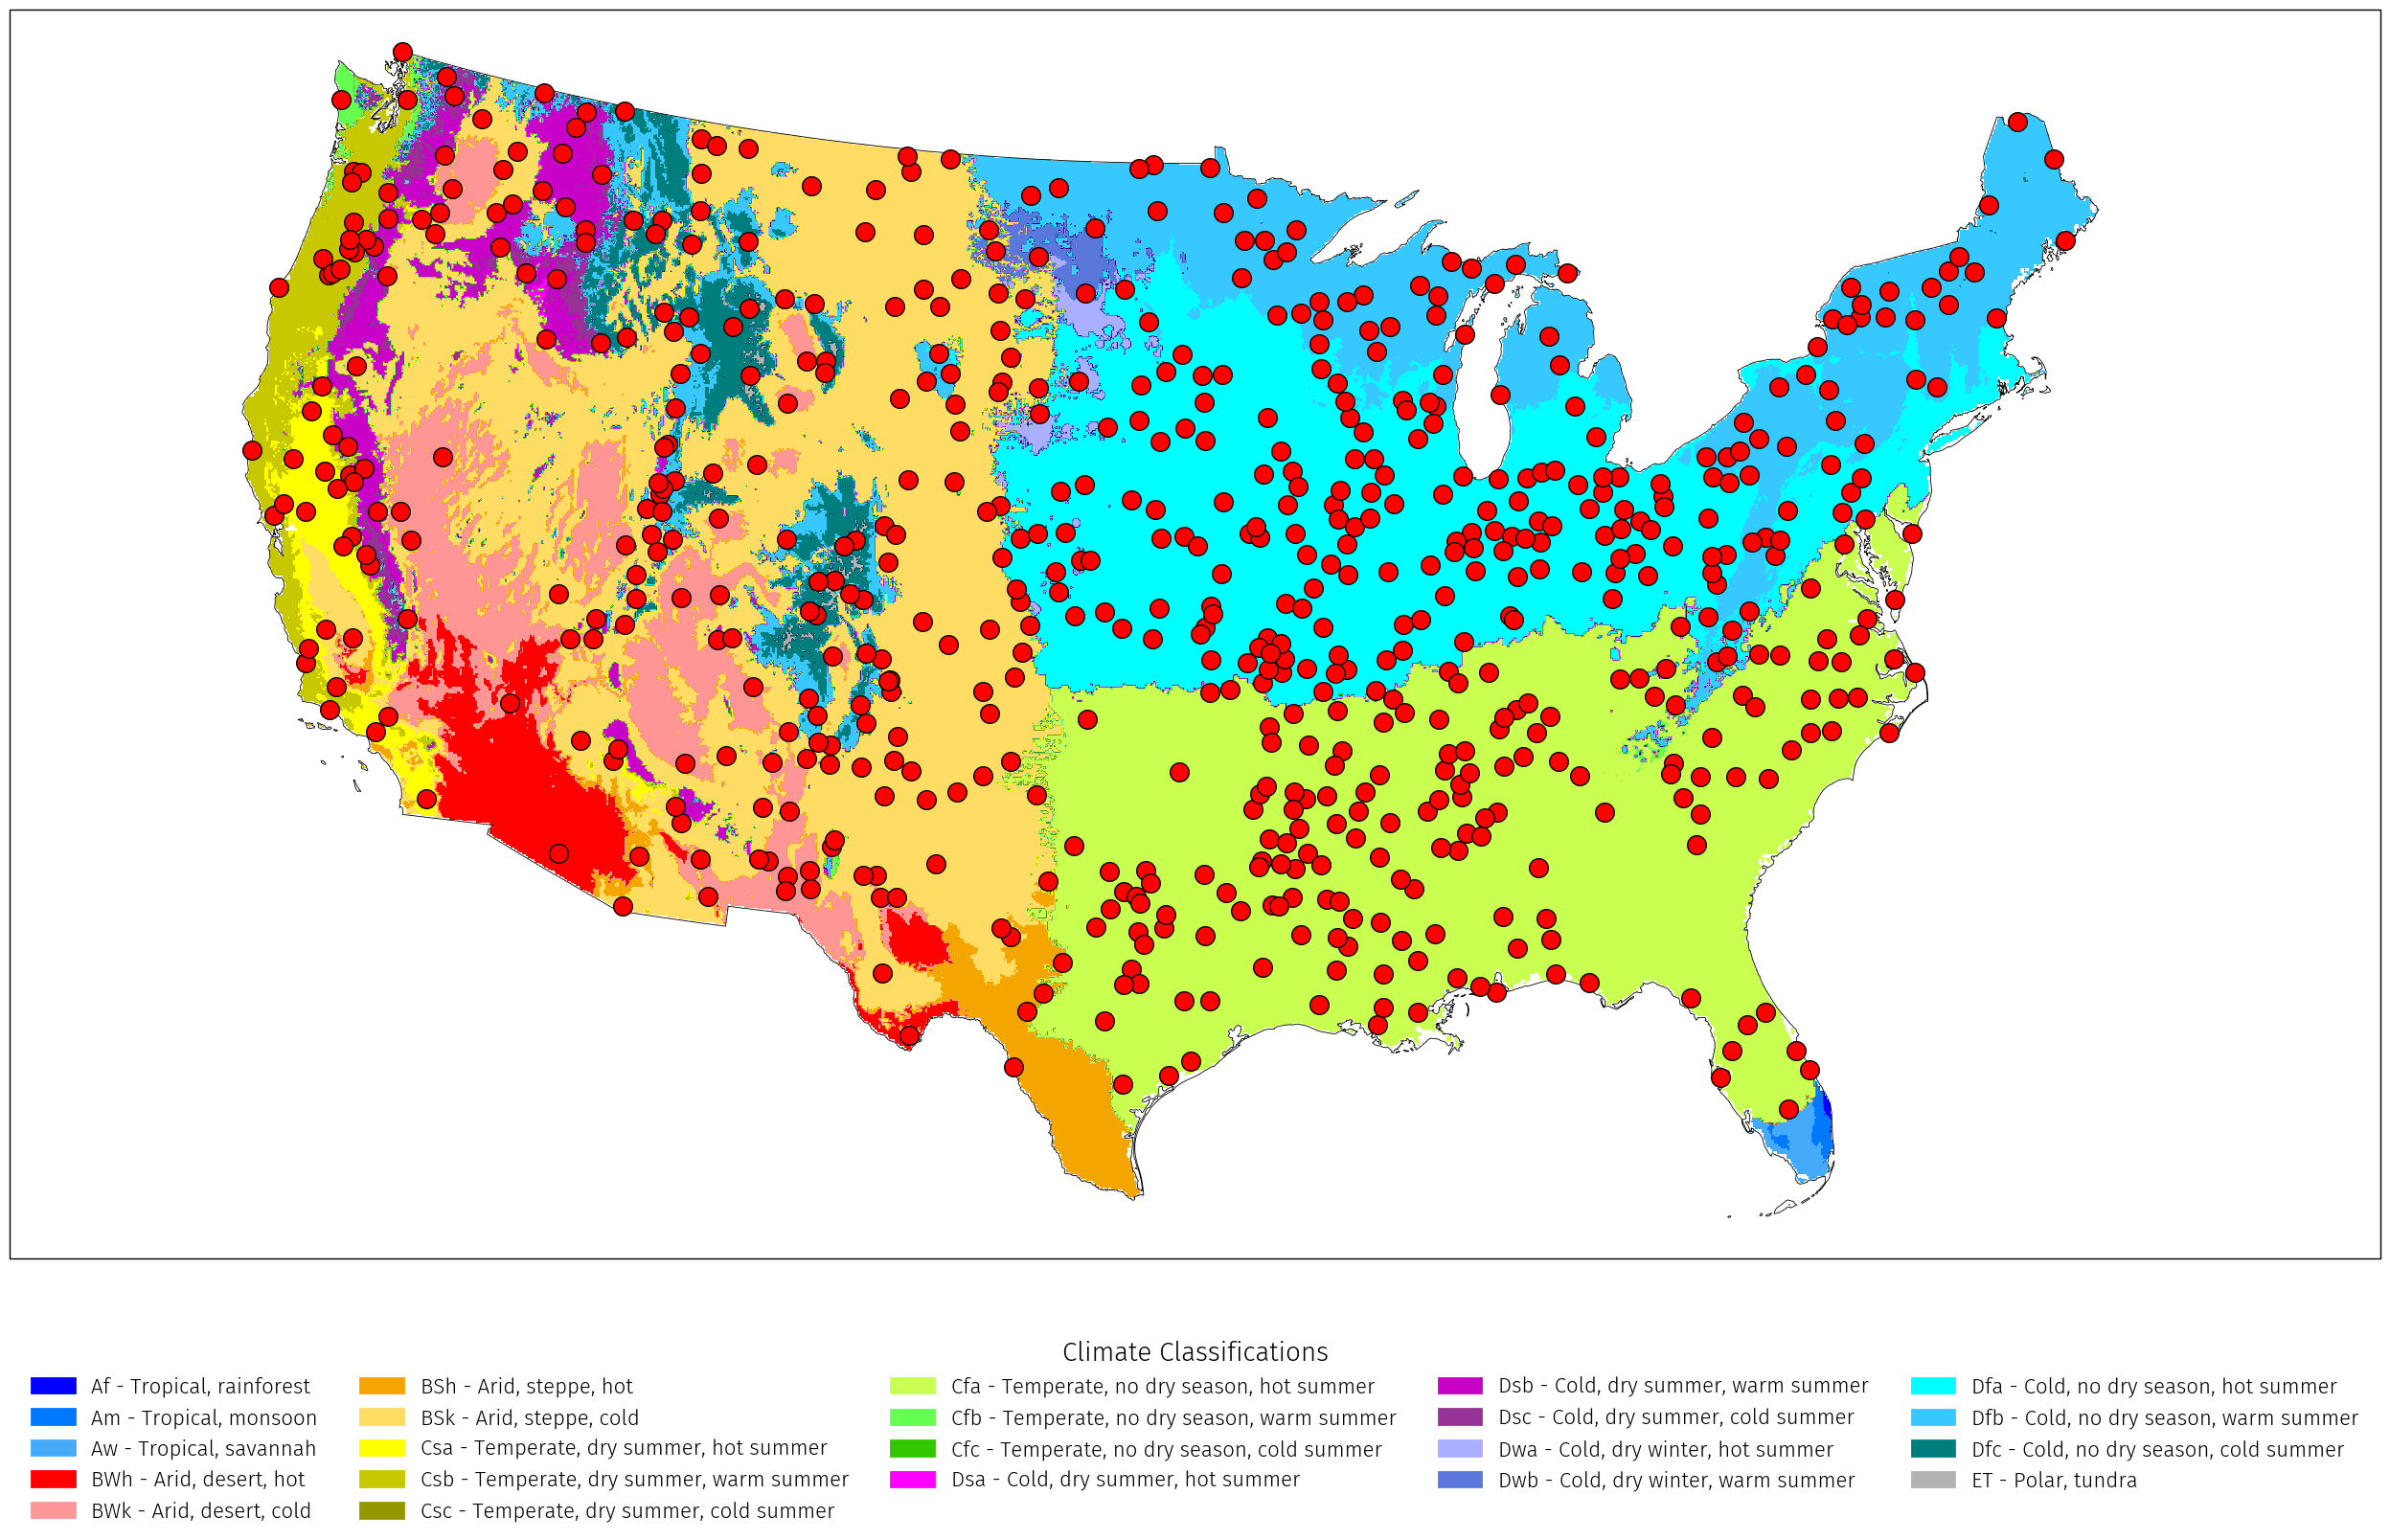

In [15]:
plot_stations(final_stations)

In [16]:
kg_counts = count_stations_in_KGZ(final_stations)
kg_counts

,count,Description
KG,,
25,172,"Dfa - Cold, no dry season, hot summer"
14,168,"Cfa - Temperate, no dry season, hot summer"
7,137,"BSk - Arid, steppe, cold"
26,74,"Dfb - Cold, no dry season, warm summer"
5,27,"BWk - Arid, desert, cold"
9,27,"Csb - Temperate, dry summer, warm summer"
18,17,"Dsb - Cold, dry summer, warm summer"
8,12,"Csa - Temperate, dry summer, hot summer"
21,5,"Dwa - Cold, dry winter, hot summer"


In [17]:
kg_counts.to_csv(DATA_DOC_PATH / "kg_counts.csv")